在开始寻找最好的模型参数（model parameters）w和b之前，我们还需要两个东西：
1. 一种模型质量的度量方式；
2. 一种能够更新模型以提高模型预测质量的方法。

In [4]:
from matplotlib.pyplot import xlabel
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

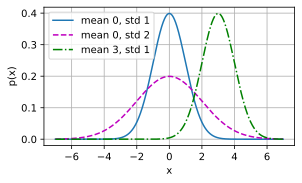

In [9]:
# 定义并可视化正态分布
def normal(x, mu, sigma):
    return 1/(math.sqrt(2*math.pi)*sigma)*np.exp(-0.5*((x-mu)**2)/sigma**2)

# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)
# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
ylabel='p(x)', figsize=(4.5, 2.5),
legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 线性回归的从零开始实现

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。在这一节中，我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。

In [3]:
%matplotlib inline
import random
import torch
import d2l

In [4]:
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, [num_examples, len(w)])
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

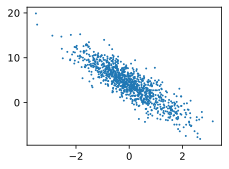

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [22]:
#该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。每个小批量包含一组特征和标签。
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
        indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [24]:
#定义模型
def linreg(X, w, b): #@save
    return torch.matmul(X, w) + b

In [63]:
#定义损失函数
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [64]:
#定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""

    """torch.no_grad() 是一个上下文管理器，其作用是临时禁止 PyTorch 进行自动求导。由于在参数更新阶段无需进行梯度计算，所以使用这个上下文管理器能够提升计算效率，同时节省内存。"""
    with torch.no_grad():
        for param in params:
            """
            这行代码是小批量随机梯度下降算法的核心更新步骤。具体而言：
            - param.grad 表示当前参数的梯度，它是在反向传播过程中由 PyTorch 自动计算得出的。
            - lr * param.grad / batch_size 计算的是参数的更新量。因为梯度是小批量样本上的梯度总和，所以要除以 batch_size 以得到平均梯度。
            - param -= ... 采用原地操作的方式更新参数，也就是直接在原参数上减去更新量。
            """
            param -= lr * param.grad / batch_size
            """param.grad.zero_() 这行代码的作用是将当前参数的梯度清零。在 PyTorch 里，梯度默认是累积的，所以在每次更新参数之后，需要手动将梯度清零，从而避免梯度累积对下一次迭代产生影响。"""
            param.grad.zero_()

In [89]:
#初始化权重，并将
w = torch.tensor([0., 0.])
b = 0

In [90]:
lr = 0.03
num_epochs =3
batch_size = 10
net = linreg
loss = squard_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [82]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.2873, -0.4656], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.6343], grad_fn=<RsubBackward1>)


In [91]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [93]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [94]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [95]:
batch_size = 10
data_iter = load_array((features, labels), batch_size, True)

In [96]:
next(iter(data_iter))

[tensor([[ 0.2982, -0.7477],
         [ 0.1266, -0.5896],
         [ 0.7669,  0.0431],
         [ 0.6088,  0.3894],
         [ 0.4173,  0.0813],
         [ 2.5875, -0.4629],
         [ 0.0967,  1.5507],
         [ 0.6778,  0.0720],
         [-0.9892,  1.0274],
         [ 0.6163, -0.4709]]),
 tensor([[ 7.3304],
         [ 6.4415],
         [ 5.5760],
         [ 4.0963],
         [ 4.7599],
         [10.9595],
         [-0.8824],
         [ 5.2882],
         [-1.2662],
         [ 7.0454]])]

In [121]:
# nn是神经网络的缩写
from torch import nn

# 第一个参数为特征形状，我们的模型有两个特征，故为2
# 第二个参数为输出特征形状，输出特征形状为单个标量（target），故为1
net = nn.Sequential(nn.Linear(2,1))

In [122]:
# MSELoss 也称为平方L2范数
loss = nn.MSELoss()

In [123]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [130]:
num_epochs = 3

for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()

        # 查找并打印模型参数的梯度
        for name, param in net.named_parameters():
            if param.grad is not None:
                print(f"Epoch {epoch + 1}, Parameter: {name}, Gradient: {param.grad}")

        trainer.step()
    print(X.grad)
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

Epoch 1, Parameter: 0.weight, Gradient: tensor([[ 0.0030, -0.0013]])
Epoch 1, Parameter: 0.bias, Gradient: tensor([0.0018])
Epoch 1, Parameter: 0.weight, Gradient: tensor([[-0.0018, -0.0017]])
Epoch 1, Parameter: 0.bias, Gradient: tensor([0.0023])
Epoch 1, Parameter: 0.weight, Gradient: tensor([[0.0004, 0.0038]])
Epoch 1, Parameter: 0.bias, Gradient: tensor([0.0033])
Epoch 1, Parameter: 0.weight, Gradient: tensor([[0.0057, 0.0108]])
Epoch 1, Parameter: 0.bias, Gradient: tensor([0.0036])
Epoch 1, Parameter: 0.weight, Gradient: tensor([[0.0023, 0.0132]])
Epoch 1, Parameter: 0.bias, Gradient: tensor([0.0019])
Epoch 1, Parameter: 0.weight, Gradient: tensor([[-0.0032, -0.0037]])
Epoch 1, Parameter: 0.bias, Gradient: tensor([-0.0076])
Epoch 1, Parameter: 0.weight, Gradient: tensor([[0.0048, 0.0008]])
Epoch 1, Parameter: 0.bias, Gradient: tensor([0.0070])
Epoch 1, Parameter: 0.weight, Gradient: tensor([[-0.0004, -0.0015]])
Epoch 1, Parameter: 0.bias, Gradient: tensor([0.0020])
Epoch 1, Parame

In [125]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0005,  0.0005])
b的估计误差： tensor([-0.0005])


## 分类问题

对分类问题，我们希望得到它的具体类别，但在实施的时候，我们获得的是它的概率。也就是说，我们使用概率模型来解决分类问题。

在分类问题中，我们使用独热编码(One-hot encoding)来标记target。比如说我们希望识别{猫、狗、猪}，我们将之编码为{(1,0,0), (0,1,0), (0,0,1)}。最终我们将得到一个模型，对任何输入，其输出一个三元矩阵(a,b,c)，分别代表输入图片为猫、狗、猪的结果。我们取最大的值所对应的动物作为分类结果。

注意到，上面我们将输出结果称为“结果”而非“概率”，这是因为结果（比方说训练一个线性回归模型）并不满足概率公理，其和未必等于1且结果可能是一个负数。要将输出视为概率，我们必须保证结果非负且和为1。
此外，我们需要一个训练的目标函数，来激励模型精准地估计概率。这个属性叫做校准(calibration)

我们使用 softmax 函数实现上述要求。对一组输出结果，softmax 函数先对每个未规范化的预测求幂，这样可以确保输出结果非负；其次再对每个结果除以它们的总和，这样就确保了结果之和为1。

$$
\begin{aligned}
\hat{\boldsymbol{y}} = \text{softmax}(\boldsymbol{o}) &&\text{其中 } \hat y_j = \dfrac{\exp(o_j)}{\sum_k \exp(o_k)}
\end{aligned}
$$

尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。因此，softmax回归是一个线性模型（linear model）。

In [3]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

In [4]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [133]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [134]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [135]:
def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover','dress','coat','sandal','shirt','sneaker','bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [136]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

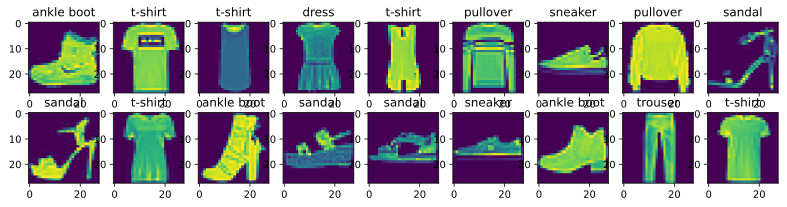

In [138]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [151]:
batch_size = 256

def get_dataloader_workers(): #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [152]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'1.70 sec'

In [153]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
                            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [154]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [10]:
import torch
from IPython import display
import d2l


batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [11]:
"""始数据集中的每个样本都是28×28的图像。本节将展平每个图像，把它们看作长度为784的向量。"""
""""在softmax回归中，我们的输出与类别一样多。因为我们的数据集有10个类别，所以网络输出维度为10。因此，权重将构成一个784 ×10的矩阵，偏置将构成一个1 ×10的行向量。与线性回归一样，我们将使用正态分布初始化我们的权重W，偏置初始化为0。"""

num_inputs = 784
num_outputs = 10

"""size=(784, 10)是因为我们为每个类别建立了这样一个映射：由784个向量的每个点建立一个向量点到类别的映射"""
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [12]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里应用了广播机制

In [13]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0335, 0.4663, 0.3386, 0.1375, 0.0241],
         [0.0856, 0.2853, 0.1509, 0.0891, 0.3891]]),
 tensor([1.0000, 1.0000]))

In [14]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [15]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])

"""
y_hat[[0, 1], y] 运用了 PyTorch 中的高级索引（也称为花式索引）来从 y_hat 张量中选取特定的元素。下面逐步分析：
- [0, 1]：这是一个索引列表，代表选取 y_hat 张量的第 0 行和第 1 行。
- y：即 [0, 2]，它也是一个索引列表，用于指定在每一行中选取的列索引。

具体来说，y_hat[[0, 1], y] 会按照以下方式选取元素：
- 对于第 0 行（[0.1, 0.3, 0.6]），根据 y 中的第一个元素 0，选取第 0 列的元素，也就是 0.1。
- 对于第 1 行（[0.3, 0.2, 0.5]），根据 y 中的第二个元素 2，选取第 2 列的元素，也就是 0.5。
"""
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [16]:
def cross_entropy(y_hat, y):
    """
    - 这里运用了 PyTorch 的高级索引（花式索引）技术。range(len(y_hat)) 作为行索引，y 作为列索引。对于每个样本，会从 y_hat 中选取真实标签对应的预测概率。
    - 具体来说，对于第 i 个样本，会选取 y_hat[i, y[i]]，即第 i 个样本真实标签对应的预测概率。
    - softmax 函数的损失函数为交叉熵损失函数
    """
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [23]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    """y_hat.shape 为 (2,3)，表示 2 行 3 列。其中，y_hat.shape[1]表示列数"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        """argmax 即取最大值的索引，axis=1 即对每行而言，取最大值列的索引"""
        y_hat = y_hat.argmax(axis=1)
    """由于等式运算符“==”对数据类型很敏感，因此我们将 y_hat 的数据类型转换为与 y 的数据类型一致。"""
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [24]:
def evaluate_accuracy(net, data_iter): #@save
    """
    计算在指定数据集上模型的精度
    - net 为模型
    - data_iter 为任意数据迭代器 data_iter 可访问的数据集
    """
    if isinstance(net, torch.nn.Module):
            net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            """
            - accuracy(net(X), y) 预测正确值为 1，预测错误值为 0
            - y.numel() 为 y 的总数，这里 y.numel() 为 1
            """
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [272]:
from d2l import torch as d2l

In [25]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self,*args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [26]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """
    该函数定义训练模型的一个迭代周期
    updater时更新模型参数的常用函数，它接受批量大小作为参数。它可以是 d2l.sgd 函数，也可以是框架的内置优化函数
    """

    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用 PyTorch 内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [27]:
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel = None, ylabel = None, legend = None,
                 xlim = None, ylim = None, xscale = "linear", yscale = "linear",
                 fmts = ('-', 'm--', 'g-', 'r:'), nrows = 1, ncols = 1,
                 figsize = (3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用 lambda 函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend
        )
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [28]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
    legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [32]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [33]:
num_epochs = 10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [212]:
def predict(net, test_iter, n=6):
    """预测标签"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[:n].reshape((n,28,28)), 1, n, titles[:n])

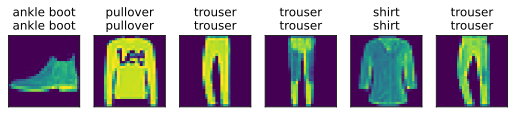

In [213]:
predict(net, test_iter)

In [216]:
import torch
from torch import nn
from d2l import torch as d2l

In [217]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [221]:
"""PyTorch 不会隐式地调整输入的形状。因此，我们在线性层前面定义了展平层(flatten)，来调整网络输入的形状"""
net = nn.Sequential(nn.Flatten(), nn.Linear(num_inputs, num_outputs))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

回想一下，softmax 函数
$$
\hat y_j = \dfrac{\exp(o_j)}{\sum_k \exp(o_k)}
$$
如果 $o_k$ 中的一些数值非常大，那么 $\exp(o_k)$ 可能大于数据类型容许的最大数字，即上溢 (overflow)。这将使分母或分子变为 `inf`（无穷大），最后得到的是 `inf`、 `0` 或是 `nan` 的 $\hat y_j$。
解决这个问题的一个技巧是：在继续 softmax 计算之前，先从所有 $o_k$ 中减去 $\max(o_k)$。这里可以看到每个 $o_k$ 按常数进行的移动不会改变 softmax 的返回值：
$$
\begin{aligned}
\hat y_j &= \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_j - \max(o_k))\exp(\max(o_k))}\\
&= \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_j - \max(o_k))}
\end{aligned}
$$
然而，在减法和规范化步骤之后，可能有些 $o_j - \max(o_k)$ 具有较大的负值。由于精度受限，$\exp(o_j - \max(o_k))$ 将有接近零的值，即下溢 (underflow)。这些值可能会四舍五入为零，使 $\hat y_j$ 为零，并且使得 $\ln(\hat y_j)$ 的值为 `-inf`。反向传播几步后将全是 `nan`。

尽管我们要计算指数函数，但我们在最终计算交叉熵损失时会取它们的对数。通过将 softmax 和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。如下面的等式所示，我们避免计算 $\exp(o_j - \max(o_k))$，而可以直接使用 $o_j - \max(o_k)$，因为 $\ln(\exp(\cdot))$ 被抵消了。
$$
\begin{aligned}
\ln(\hat y_j) &= \ln\left(\dfrac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))} \right)\\
&= \ln(\exp(o_j - \max(o_k))) - \ln\left(\sum_k \exp(o_k - \max(o_k)) \right)\\
&= o_j - \max(o_k) - \ln\left(\sum\limits_k \exp(o_k) - \max(o_k) \right).
\end{aligned}
$$
而最下边的 ln 函数因为要计算所有指数值之和，所以下溢造成的误差就可以忽略不计了。

In [222]:
loss = nn.CrossEntropyLoss(reduction='none')

In [223]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [261]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [232]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')
